Cupy is a library for vector-matrix calculations with some math functions, which work with data stored on GPU. Syntax is similar to numpy, but with few additions like Kernel functions. So the main difference between Cupy and Numpy is that numpy process all data on cpu, while Cupy on GPU.

To move data from gpu to cpu cupy has methods such cp.as_numpy() or get(). To switch from cpu to gpu one can just use cp.array(numpy_array) or cp.asarray(numpy_array).

In [1]:
!nvidia-smi

Wed Dec 13 15:12:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.33.01              Driver Version: 546.29       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        On  | 00000000:01:00.0 Off |                  N/A |
| N/A   69C    P0              N/A / ERR! |      0MiB /  3072MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0


In [4]:
# !pip install cupy-cuda11x

In [5]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from cupyx.profiler import benchmark
import time
from tqdm import tqdm
from joblib import Parallel, delayed
import subprocess
import os

import warnings
warnings.filterwarnings('ignore')

In [6]:
def saxpy(x, y, alpha=3):
   z = alpha * x + y
   return z

@cp.fuse()
def cupy_saxpy(x, y, alpha=3):
   z = alpha * x + y
   return z

In [7]:
def calculate_time(lib):
    time_array = []

    for i in tqdm(range(3, 23)):
        x = lib.random.rand(2**i).astype(lib.float32)
        y = lib.random.rand(2**i).astype(lib.float32)

        if lib == np:
            start = time.perf_counter()
            res = saxpy(x, y)
            elapsed_time = time.perf_counter() - start
        else:
            start = time.perf_counter()
            res = cupy_saxpy(x, y)
            elapsed_time = time.perf_counter() - start
        time_array.append(elapsed_time)

    return time_array

In [10]:
numpy_times = calculate_time(np)
cupy_times = calculate_time(cp)

100%|██████████| 20/20 [00:00<00:00, 659.25it/s]


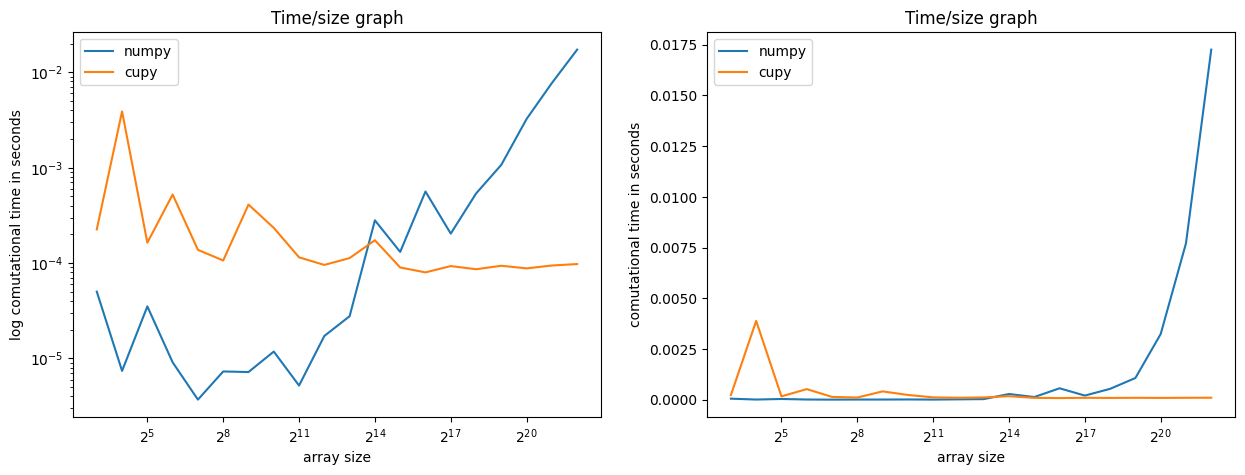

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(2**np.arange(3, 23), numpy_times, label='numpy')
axes[0].plot(2**np.arange(3, 23), cupy_times, label='cupy')
axes[0].set_xscale('log', base=2)
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title('Time/size graph')
axes[0].set_ylabel('log comutational time in seconds')
axes[0].set_xlabel('array size')

axes[1].plot(2**np.arange(3, 23), numpy_times, label='numpy')
axes[1].plot(2**np.arange(3, 23), cupy_times, label='cupy')
axes[1].set_xscale('log', base=2)
axes[1].legend()
axes[1].set_title('Time/size graph')
axes[1].set_ylabel('comutational time in seconds')
axes[1].set_xlabel('array size')

plt.show()

## Cupy bifurcation

In [12]:
@cp.fuse()
def bifurcation_map_cupy(x, r):
    return r * x * (1 - x)

def calculate_last_ms_cupy(rs, x0, n, m):
    last_ms = [0.0] * m
    x = cp.zeros(rs.shape, dtype=cp.float32) + x0

    for i in range(n):
        x = bifurcation_map_cupy(x, rs)

    for i in range(m):
        x = bifurcation_map_cupy(x, rs)
        last_ms[i] = bifurcation_map_cupy(x, rs)

    return last_ms

def bifurcation_map(x, r):
    return r * x * (1 - x)

def calculate_last_ms(rs, x0, n, m):
    last_ms = [0.0] * m
    x = np.zeros(rs.shape, dtype=np.float32) + x0
    #x = np.array([x0 for _ in rs])

    for i in range(n):
        x = bifurcation_map(x, rs)

    for i in range(m):
        x = bifurcation_map(x, rs)
        last_ms[i] = x

    return last_ms

In [13]:
n = 3000
m = 200
x0 = 0.1
N = 8

In [14]:
%%writefile parallel_bifurcation.py
from mpi4py import MPI
import numpy as np
import time
import sys

def bifurcation_map(x, r):
    return r * x * (1 - x)

def calculate_last_ms(rs, x0, n, m):
    last_ms = [0.0] * m
    x = np.zeros(rs.shape, dtype=np.float32) + x0
    #x = np.array([x0 for _ in rs])

    for i in range(n):
        x = bifurcation_map(x, rs)

    for i in range(m):
        x = bifurcation_map(x, rs)
        last_ms[i] = x

    return last_ms

comm = MPI.COMM_WORLD

rank = comm.Get_rank()
size = comm.Get_size()

r_size = int(sys.argv[1])
a = 2
b = 5
n = 3000
m = 200
x0 = 0.1
root = 0
dr = (b - a) / (r_size-1)

my_N = r_size // size
remainder = r_size % size

if (rank < remainder):
    my_N += 1

if (rank - 1) < remainder:
    shift = rank * (my_N + 1)
else:
    shift = (my_N + 1) * remainder + my_N * (rank - remainder)

rs = np.linspace(0, dr * (my_N-1), my_N) + shift * dr + a
my_part = calculate_last_ms(rs, x0, n, m)

maps = comm.gather(my_part, root=root)

MPI.Finalize()

Overwriting parallel_bifurcation.py


In [17]:
numpy_times = []
cupy_times = []
parallel_times = []
mpi_times = []
r_sizes = [2**i for i in range(3, 19)]

for r_size in tqdm(r_sizes):
    rs = np.linspace(2, 5, r_size)

    start = time.perf_counter()
    res = calculate_last_ms(rs, x0, n, m)
    elapsed_time = time.perf_counter() - start
    numpy_times.append(elapsed_time)

    list_array = np.array_split(rs, N)
    start = time.perf_counter()
    res = Parallel(n_jobs=N, verbose=0)(delayed(calculate_last_ms)(array, x0, n, m) for array in list_array)
    elapsed_time = time.perf_counter() - start
    parallel_times.append(elapsed_time)

    mpi_time = %timeit -o -n 1 -r 1 os.system(f'mpirun -n 4 --allow-run-as-root --oversubscribe python3 parallel_bifurcation.py {r_size}')
    mpi_times.append(mpi_time.average)

    rs = cp.linspace(2, 5, r_size)
    start = time.perf_counter()
    res = calculate_last_ms_cupy(rs, x0, n, m)
    elapsed_time = time.perf_counter() - start
    cupy_times.append(elapsed_time)

  0%|          | 0/16 [00:00<?, ?it/s]

/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)


1.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


  6%|▋         | 1/16 [00:02<00:33,  2.23s/it]/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
 12%|█▎        | 2/16 [00:03<00:23,  1.65s/it]

1.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)


981 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


 19%|█▉        | 3/16 [00:04<00:19,  1.47s/it]/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)


1.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


 25%|██▌       | 4/16 [00:06<00:17,  1.42s/it]/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
 31%|███▏      | 5/16 [00:07<00:14,  1.31s/it]

866 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
 38%|███▊      | 6/16 [00:08<00:12,  1.22s/it]

821 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
 44%|████▍     | 7/16 [00:09<00:10,  1.20s/it]

958 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
 50%|█████     | 8/16 [00:10<00:09,  1.18s/it]

856 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
 56%|█████▋    | 9/16 [00:11<00:08,  1.20s/it]

972 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
 62%|██████▎   | 10/16 [00:13<00:07,  1.24s/it]

969 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)


1.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


 69%|██████▉   | 11/16 [00:14<00:06,  1.38s/it]/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
 75%|███████▌  | 12/16 [00:17<00:06,  1.63s/it]

1.16 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)


1.39 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


 81%|████████▏ | 13/16 [00:19<00:05,  1.88s/it]/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)


1.56 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


 88%|████████▊ | 14/16 [00:23<00:04,  2.40s/it]/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
 94%|█████████▍| 15/16 [00:29<00:03,  3.60s/it]

2.64 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/tmp/ipykernel_703/130039392.py:19: RuntimeWarning: overflow encountered in multiply
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)
/home/bogdan/skoltech/hppl/parallel_bifurcation.py:7: RuntimeWarning: overflow encountered in multiply
  return r * x * (1 - x)


6.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


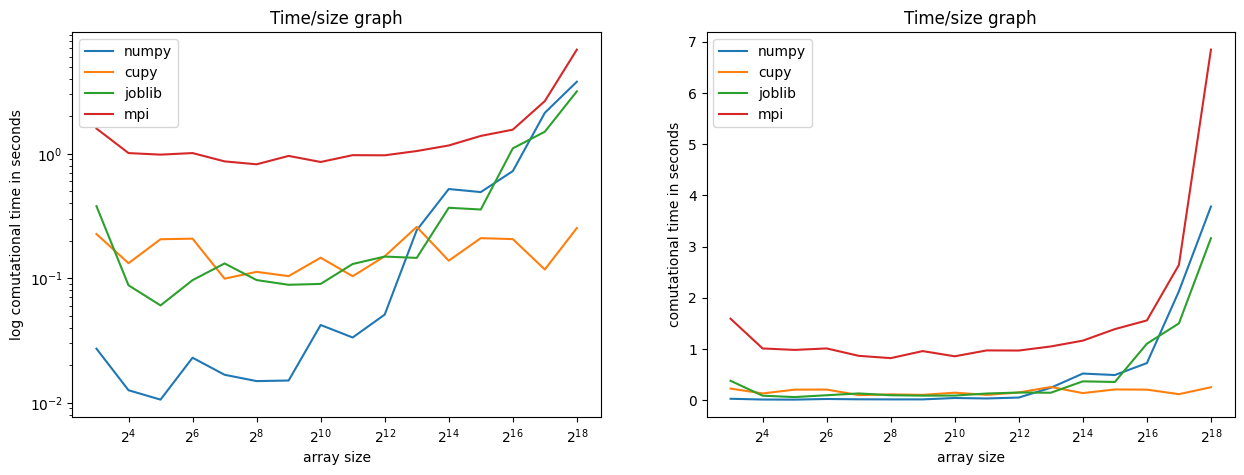

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(r_sizes, numpy_times, label='numpy')
axes[0].plot(r_sizes, cupy_times, label='cupy')
axes[0].plot(r_sizes, parallel_times, label='joblib')
axes[0].plot(r_sizes, mpi_times, label='mpi')
axes[0].set_xscale('log', base=2)
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_title('Time/size graph')
axes[0].set_ylabel('log comutational time in seconds')
axes[0].set_xlabel('array size')

axes[1].plot(r_sizes, numpy_times, label='numpy')
axes[1].plot(r_sizes, cupy_times, label='cupy')
axes[1].plot(r_sizes, parallel_times, label='joblib')
axes[1].plot(r_sizes, mpi_times, label='mpi')
axes[1].set_xscale('log', base=2)
axes[1].legend()
axes[1].set_title('Time/size graph')
axes[1].set_ylabel('comutational time in seconds')
axes[1].set_xlabel('array size')

plt.show()